In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from scipy import ndimage
from scipy.ndimage import rotate
import zipfile
import random
from keras.utils import get_file
from sklearn.model_selection import train_test_split
from keras.utils import Sequence

In [ ]:
url_1 = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
url_2 = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"

file_path = "c:\\Users\\maxim\\OneDrive\\Desktop\\Research\\Experiment_1\\datasets\\CT-0.zip"
if os.path.exists(file_path):
    os.remove(file_path)  # Deletes the incomplete file

# Directory where the files will be stored
cache_dir = os.getcwd()  # Current working directory

# Download the first file
filename_1 = get_file("CT-0.zip", url_1, cache_dir=cache_dir)

# Download the second file
filename_2 = get_file("CT-23.zip", url_2, cache_dir=cache_dir)

# Make a directory to store the data
os.makedirs("CT_Data", exist_ok=True)  # Using exist_ok=True to avoid errors if the directory exists

# Unzip the first file
with zipfile.ZipFile(filename_1, "r") as z_fp:
    z_fp.extractall("./CT_Data/")

# Unzip the second file
with zipfile.ZipFile(filename_2, "r") as z_fp:
    z_fp.extractall("./CT_Data/")

In [4]:
# Function to load a .nii.gz file
def load_nii(file_path):
    return nib.load(file_path).get_fdata()

def save_nii(volume, save_path):
    new_img = nib.Nifti1Image(volume, np.eye(4))  # Assuming the affine matrix is identity
    nib.save(new_img, save_path)

# Function to apply a random rotation to the volume
def random_rotate(volume):
    angle = random.uniform(0, 360)
    return rotate(volume, angle, axes=(0, 1), reshape=False)  # Rotate around the first two axes

# Function to apply gaussian noise
def add_gaussian_noise(img, mean=0, std=0.05):
    noise = np.random.normal(mean, std, img.shape)
    return np.clip(img + noise, 0, 1)  # Ensuring pixel values stay valid

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]

    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = load_nii(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume



In [5]:
def create_multiview_dataset(base_path, ct_folders):
    for ct_folder in ct_folders:
        folder_path = os.path.join(base_path, ct_folder)
        # List all items in the folder and process only files (not directories)
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)

            # Skip hidden files (those starting with a dot) and directories
            if item.startswith('.') or os.path.isdir(item_path):
                continue  # Skip hidden files or directories

            if os.path.isfile(item_path) and item.endswith('.nii.gz'):  # Check if it's a .nii.gz file
                try:
                    # Load the original CT scan image
                    original_volume = process_scan(item_path)

                    # Create subdirectory for each file (based on the file name without extension)
                    study_dir_name = os.path.splitext(item)[0]  # Get the file name without extension
                    study_save_dir = os.path.join(folder_path, study_dir_name)
                    os.makedirs(study_save_dir, exist_ok=True)

                    # Save the original image
                    save_nii(original_volume, os.path.join(study_save_dir, f"{study_dir_name}_original.nii.gz"))

                    # Save the rotated image
                    rotated_volume = random_rotate(original_volume)
                    save_nii(rotated_volume, os.path.join(study_save_dir, f"{study_dir_name}_rotated.nii.gz"))

                    # Save the noised image
                    gaussian_volume = add_gaussian_noise(original_volume)
                    save_nii(gaussian_volume, os.path.join(study_save_dir, f"{study_dir_name}_noise.nii.gz"))

                except Exception as e:
                    print(f"Error processing {item_path}: {e}")

# Directory structure
base_directory = "CT_Data"
ct_folders = ["CT-0", "CT-23"]

# Create multi-view dataset
create_multiview_dataset(base_directory, ct_folders)


In [6]:
def count_directories(path):
    # List all items in the directory and filter for directories
    return len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

# Example usage:
path = "CT_Data/CT-23"
path2 = "CT_Data/CT-0"
print(f"Number of directories: {count_directories(path2)}")
print(f"Number of directories: {count_directories(path)}")

Number of directories: 100
Number of directories: 100


In [7]:
base_path = './CT_Data/CT-0'
base_path_2 = './CT_Data/CT-23'


def delete_files(base_path):

    # Iterate through the files in CT_Data
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)

        # Check if it's a file and if it ends with '.gz'
        if os.path.isfile(item_path) and item.endswith('.gz'):
            os.remove(item_path)  # Delete the file
            print(f"Deleted file: {item_path}")


delete_files(base_path)
delete_files(base_path_2)



Deleted file: ./CT_Data/CT-0\study_0001.nii.gz
Deleted file: ./CT_Data/CT-0\study_0002.nii.gz
Deleted file: ./CT_Data/CT-0\study_0003.nii.gz
Deleted file: ./CT_Data/CT-0\study_0004.nii.gz
Deleted file: ./CT_Data/CT-0\study_0005.nii.gz
Deleted file: ./CT_Data/CT-0\study_0006.nii.gz
Deleted file: ./CT_Data/CT-0\study_0007.nii.gz
Deleted file: ./CT_Data/CT-0\study_0008.nii.gz
Deleted file: ./CT_Data/CT-0\study_0009.nii.gz
Deleted file: ./CT_Data/CT-0\study_0010.nii.gz
Deleted file: ./CT_Data/CT-0\study_0011.nii.gz
Deleted file: ./CT_Data/CT-0\study_0012.nii.gz
Deleted file: ./CT_Data/CT-0\study_0013.nii.gz
Deleted file: ./CT_Data/CT-0\study_0014.nii.gz
Deleted file: ./CT_Data/CT-0\study_0015.nii.gz
Deleted file: ./CT_Data/CT-0\study_0016.nii.gz
Deleted file: ./CT_Data/CT-0\study_0017.nii.gz
Deleted file: ./CT_Data/CT-0\study_0018.nii.gz
Deleted file: ./CT_Data/CT-0\study_0019.nii.gz
Deleted file: ./CT_Data/CT-0\study_0020.nii.gz
Deleted file: ./CT_Data/CT-0\study_0021.nii.gz
Deleted file:

In [8]:
print(f"Number of directories: {count_directories(path2)}")
print(f"Number of directories: {count_directories(path)}")

Number of directories: 100
Number of directories: 100


In [9]:
class MultiModalDataset(Sequence):
    def __init__(self, patient_dirs, labels, batch_size, shuffle=True):
        self.patient_dirs = patient_dirs
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.patient_dirs))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.patient_dirs) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_patient_dirs = [self.patient_dirs[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]
        
        # Load modalities
        X = self.__load_modalities(batch_patient_dirs)
        y = np.array(batch_labels)
        
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __load_modalities(self, patient_dirs):
        modalities = {'original': [], 'rotated': [], 'noise': []}
        
        for patient_dir in patient_dirs:
            patient_name = os.path.basename(patient_dir)
        
            original_path = os.path.join(patient_dir, f'{patient_name}_original.nii.gz')
            rotated_path = os.path.join(patient_dir, f'{patient_name}_rotated.nii.gz')
            noise_path = os.path.join(patient_dir, f'{patient_name}_noise.nii.gz')
            
            # Load each modality
            original = load_nii(original_path)
            rotated = load_nii(rotated_path)
            noise = load_nii(noise_path)
            
            # Append to the list for the batch
            modalities['original'].append(original)
            modalities['rotated'].append(rotated)
            modalities['noise'].append(noise)
        # Stack the modalities for each patient along the first axis (batch axis)
        X = [
            np.array(modalities['original']),
            np.array(modalities['rotated']),
            np.array(modalities['noise'])
        ]
        
        return X

# Define the paths to your directories
healthy_dir = './CT_Data/CT-0'
non_healthy_dir = './CT_Data/CT-23'

# List all patient directories (assuming each patient has a folder in each group)
healthy_patients = [os.path.join(healthy_dir, f) for f in os.listdir(healthy_dir) if os.path.isdir(os.path.join(healthy_dir, f))]
non_healthy_patients = [os.path.join(non_healthy_dir, f) for f in os.listdir(non_healthy_dir) if os.path.isdir(os.path.join(non_healthy_dir, f))]

# Initialize lists to hold the data and labels
patient_dirs = []  # Will hold paths to the patient directories
labels = []  # Will hold the labels (0 for healthy, 1 for non-healthy)

# Load the data from healthy patients
for patient in healthy_patients:
    patient_dirs.append(patient)
    labels.append(0)  # Label 0 for healthy

# Load the data from non-healthy patients
for patient in non_healthy_patients:
    patient_dirs.append(patient)
    labels.append(1)  # Label 1 for non-healthy

# Convert to NumPy arrays
patient_dirs = np.array(patient_dirs)
labels = np.array(labels)

# Shuffle the data
indices = np.arange(len(patient_dirs))
np.random.shuffle(indices)

patient_dirs = patient_dirs[indices]
labels = labels[indices]

# Split the data into training and testing sets (80/20)
patient_dirs_train, patient_dirs_test, labels_train, labels_test = train_test_split(patient_dirs, labels, test_size=0.2, random_state=42)

# Create the training and testing dataset objects
train_dataset = MultiModalDataset(patient_dirs_train, labels_train, batch_size=1, shuffle=True)
test_dataset = MultiModalDataset(patient_dirs_test, labels_test, batch_size=1, shuffle=False)

# Check the length of the datasets
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")
print(f"Labels Dataset Length: {len(labels)}")

print("\n")

X, y = train_dataset[0]

for modality, data in zip(['original', 'rotated', 'zoom'], X):
    print(f"Shape of {modality} modality: {data.shape}")
    
print(f"label: {y}")


Train Dataset Length: 160
Test Dataset Length: 40
Labels Dataset Length: 200


Shape of original modality: (1, 128, 128, 64)
Shape of rotated modality: (1, 128, 128, 64)
Shape of zoom modality: (1, 128, 128, 64)
label: [1]


Number of scans: 3
Dimension of CT scan: (128, 128, 64)
label= [1]




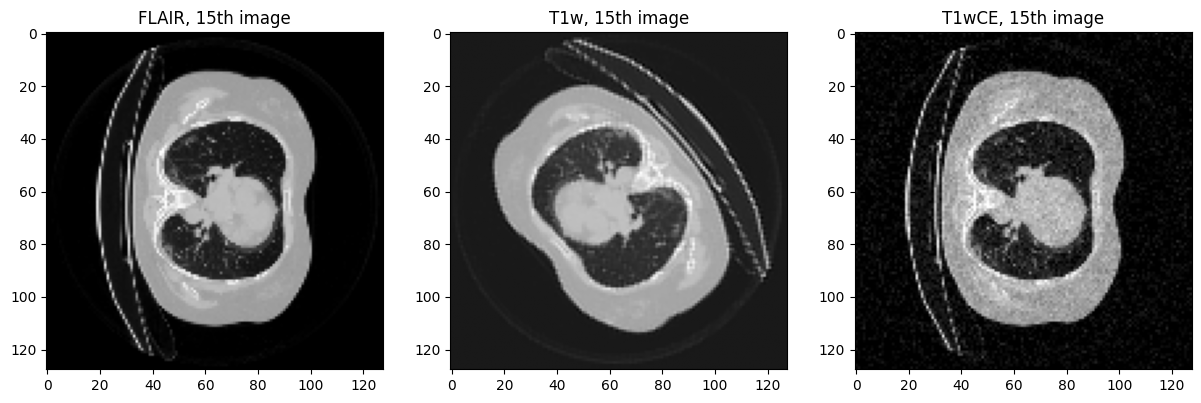

In [11]:
fig = plt.figure(figsize=(20,8))

for i in range(1):
    scans, label = train_dataset[i]
    print("Number of scans:", len(scans))
    print("Dimension of CT scan:", scans[0][0].shape)
    print("label=",label)
    print("\n")
    
    ax1 = plt.subplot(1,4,1)
    ax1.imshow(scans[0][0][:,:,32], cmap="gray")
    ax1.set_title("FLAIR, 15th image")
    ax2 = plt.subplot(1,4,2)
    ax2.imshow(scans[1][0][:,:,32], cmap="gray")
    ax2.set_title("T1w, 15th image")
    ax3 = plt.subplot(1,4,3)
    ax3.imshow(scans[2][0][:,:,32], cmap="gray")
    ax3.set_title("T1wCE, 15th image")